In [4]:
import Quandl
import numpy as np
from scipy import stats
import statsmodels
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

- natural resources (WWDI/USA_NY_GDP_TOTL_RT_ZS - 1970)
- immigration
- unemployment (FRED/UNRATE - 1948)
- regulations (WWGI/USA_RQ_EST - 1996)
- cpi (WORLDBANK/USA_FP_CPI_TOTL_ZG - 1961)
- R&D INVESTMENT (NSF/IND_R_D - 1953)

- education (college graduates? literacy? graduation rate?)

- researchers (WWDI/USA_SP_POP_SCIE_RD_P6 - 1996)
- doctorate recepients (NSF/DOCTORATES - 1957)
- doctorate granting instiutions (NSF/DOC_INST - 1970)
- venture capital deals(NVCA/VENTURE_3_11 - 1985)

In [5]:
patents = Quandl.get("USPTO/PAT_ACT")
patents = patents['Utility Patents']

In [6]:
patents.head()

Year
1790-12-31     3.0
1791-12-31    33.0
1792-12-31    11.0
1793-12-31    20.0
1794-12-31    22.0
Name: Utility Patents, dtype: float64

In [7]:
regulations = Quandl.get("WWGI/USA_RQ_EST")

### [Natural Resources as a percentage of GDP](https://www.quandl.com/data/WWDI/USA_NY_GDP_TOTL_RT_ZS-Total-natural-resources-rents-of-GDP-United-States)

In [8]:
natural_resources = Quandl.get("WWDI/USA_NY_GDP_TOTL_RT_ZS")
natural_resources = natural_resources['Value']
natural_resources.name = 'Natural Resources'
natural_resources /= 100

In [9]:
natural_resources.head()

Date
1970-12-31    0.010006
1971-12-31    0.010355
1972-12-31    0.009789
1973-12-31    0.012949
1974-12-31    0.035525
Name: Natural Resources, dtype: float64

### [R&D Investment](https://www.quandl.com/data/NSF/IND_R_D-Industrial-R-D-Performed-in-the-United-States-by-Source-of-Funds)

In [10]:
rd_investment = Quandl.get("NSF/IND_R_D")
rd_investment = rd_investment['All Sources (Constant $)']
rd_investment.name = 'R&D Investment'
rd_investment *= 1000000

In [11]:
rd_investment.head()

Year
1953-12-31    1.990100e+10
1954-12-31    2.209600e+10
1955-12-31    2.474700e+10
1956-12-31    3.406400e+10
1957-12-31    3.857800e+10
Name: R&D Investment, dtype: float64

### [Number of Doctorates](https://www.quandl.com/data/NSF/DOCTORATES--Doctorate-Recipients-from-U-S-Colleges-and-Universities)

In [12]:
doctorates = Quandl.get("NSF/DOCTORATES")
doctorates = doctorates['Number']
doctorates.name = '# of Doctorates'
doctorates = doctorates.shift(-1, freq='D')

### [Number of Venture Capital Deals](https://www.quandl.com/data/NVCA/VENTURE_3_11-Venture-Capital-Investments-By-State-Number-of-Deals)

In [13]:
venture_capital = Quandl.get("NVCA/VENTURE_3_11")
venture_capital = venture_capital['Total']
venture_capital.name = '# of VC Deals'

In [14]:
venture_capital.head()

Year
1985-12-31    1345.0
1986-12-31    1421.0
1987-12-31    1646.0
1988-12-31    1526.0
1989-12-31    1544.0
Name: # of VC Deals, dtype: float64

In [15]:
list_of_factors = [natural_resources, rd_investment, doctorates, venture_capital]

In [16]:
factors = pd.concat(list_of_factors, 1)

In [17]:
factors.head()

,Natural Resources,R&D Investment,# of Doctorates,# of VC Deals
1953-12-31,NaN,1.990100e+10,NaN,NaN
1954-12-31,NaN,2.209600e+10,NaN,NaN
1955-12-31,NaN,2.474700e+10,NaN,NaN
1956-12-31,NaN,3.406400e+10,8611.0,NaN
1957-12-31,NaN,3.857800e+10,8773.0,NaN


In [18]:
factors = factors.dropna()
factors.head()

,Natural Resources,R&D Investment,# of Doctorates,# of VC Deals
1985-12-31,0.021947,1.208420e+11,31897.0,1345.0
1986-12-31,0.009654,1.232600e+11,32365.0,1421.0
1987-12-31,0.009816,1.258950e+11,33497.0,1646.0
1988-12-31,0.007457,1.281740e+11,34325.0,1526.0
1989-12-31,0.007373,1.299070e+11,36065.0,1544.0


In [19]:
def trim_data(target, factors):
    start = np.max([factors.index.min(), patents.index.min()])
    end = np.min([factors.index.max(), patents.index.max()])
    
    factors = factors[start:end]
    target = target[start:end]
    
    return target, factors

In [20]:
patents, factors = trim_data(patents, factors)

In [21]:
patents.head()

Year
1985-12-31    71661.0
1986-12-31    70860.0
1987-12-31    82952.0
1988-12-31    77924.0
1989-12-31    95537.0
Name: Utility Patents, dtype: float64

In [22]:
factors.head()

,Natural Resources,R&D Investment,# of Doctorates,# of VC Deals
1985-12-31,0.021947,1.208420e+11,31897.0,1345.0
1986-12-31,0.009654,1.232600e+11,32365.0,1421.0
1987-12-31,0.009816,1.258950e+11,33497.0,1646.0
1988-12-31,0.007457,1.281740e+11,34325.0,1526.0
1989-12-31,0.007373,1.299070e+11,36065.0,1544.0


# Visualise Data

/usr/local/lib/python3.4/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


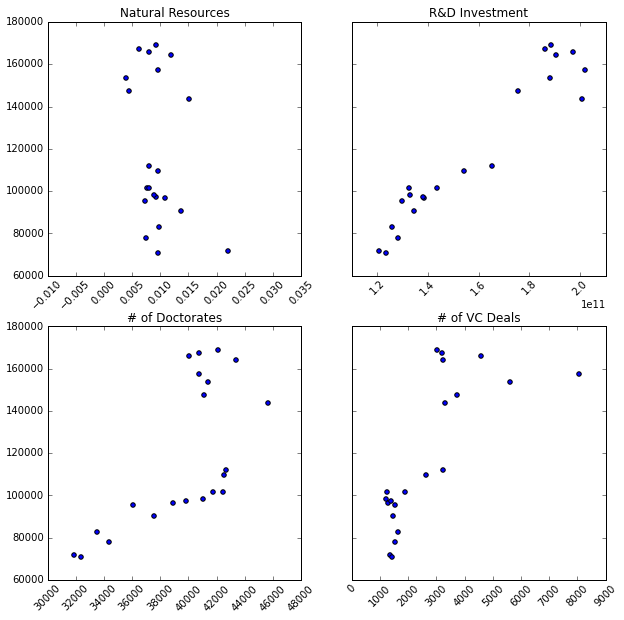

In [23]:
f, axes = plt.subplots(2, 2, sharey=True, figsize=(10,10))
for factor, ax in zip(factors, axes.ravel()):
    ax.scatter(factors[factor], patents);
    ax.set_title(factor)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

# Model

### Train-Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(factors, patents, test_size=0.25)

### Fit model

In [25]:
model = LinearRegression()

In [26]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### r-squared of model on training set

In [27]:
model.score(X_train, y_train)

0.96613847227621719

### r-squared of model on testing set

In [28]:
model.score(X_test, y_test)

0.80249152315299122

In [108]:
model_factors = sm.add_constant(factors)
model = sm.OLS(patents, model_factors)
results = model.fit()

In [109]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Utility Patents   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     66.24
Date:                Sat, 03 Dec 2016   Prob (F-statistic):           9.45e-10
Time:                        19:19:06   Log-Likelihood:                -218.81
No. Observations:                  21   AIC:                             447.6
Df Residuals:                      16   BIC:                             452.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const             -3.054e+04   3.59e+04     -0.852      0.407     -1.07e+05  4.55e+04
Natural Resources -1.414e+06   5.95e+05     -2.376      0.030     -2.68e+06 -1.52e+05
R&D Investment      1.29e-06   1.27e-07     10.150      0.000      1.02e-06  1.56e-06
# of Doctorates    -720.1309    774.507     -0.930      0.366     -2362.012   921.750
# of VC Deals        -4.3324      2.286     -1.895      0.076        -9.178     0.514
==============================================================================
Omnibus:                        4.266   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                2.973
Skew:                          -0.921   Prob(JB):                        0.226
Kurtosis:                       3.061   Cond. No.                     4.69e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""